### Imports

In [5]:
# IMPORTS
import os
import time

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
    CSVLogger
)

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow

### Dataset Setup

In [6]:
#Dataset Path
dataset_path = r'..\dataset'
train_path = os.path.join(dataset_path, 'train_set')
dev_path = os.path.join(dataset_path, 'dev_set')
test_path = os.path.join(dataset_path, 'test_set')

#Hyperparameters
batch_size = 16
IMG_SIZE = (224, 224) # Resize all images to 224x224

#Dataset split
train_set = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode = 'categorical',
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

dev_set = image_dataset_from_directory(
    dev_path,
    labels="inferred",
    label_mode = 'categorical',
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

test_set = image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode = 'categorical',
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

Found 21715 files belonging to 3 classes.
Found 5417 files belonging to 3 classes.
Found 6788 files belonging to 3 classes.


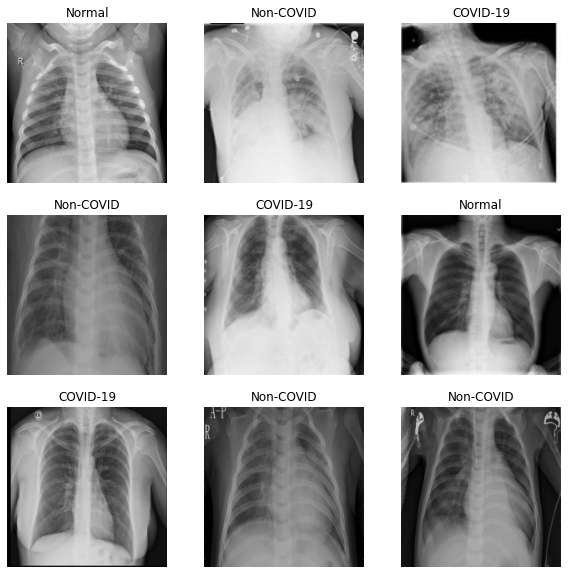

In [7]:
# Visualize Data
class_names = train_set.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

### Data Augmentation

In [8]:
# Define Data Augmentation function
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tfl.RandomFlip('horizontal'))
    data_augmentation.add(tfl.RandomRotation(0.10))
    return data_augmentation

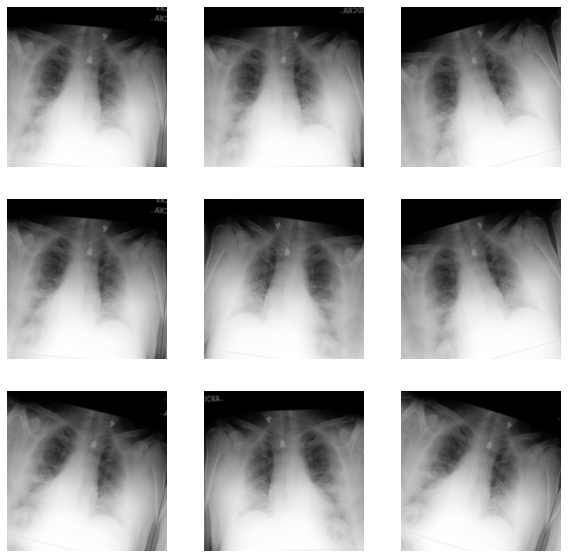

In [9]:
# Visualize Data Augmentation
data_augmentation = data_augmenter()

for image, _ in train_set.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training = True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Define Model

In [10]:
############################################
#   - Define the base model, do not include top (prediction) layers, grab weights from imagenet dataset
#   - Freeze layers by setting base_model.trainable = False
#   - Define inputs
#   - Apply Data Augmentation
#   - Preproccess Inputs with the preproccess utility
#   - Set Training = False for base_model in order not to update Batch Norm values
############################################

input_shape = IMG_SIZE + (3,)

# Define ResNet50 base model with weights from imagenet. Do NOT include top classification layers.
base_model = tf.keras.applications.resnet_v2.ResNet101V2(
    input_shape=input_shape, include_top=False, weights="imagenet"
)

# Freeze base model
base_model.trainable = False

# Define input layer
inputs = tf.keras.Input(shape=input_shape)

# Apply Data Augmentation
x = data_augmentation(inputs)

# Preproccess input using the same weights base model was trained on
x = tf.keras.applications.resnet_v2.preprocess_input(x)

# Set training = False to disable Batch Norm layers from updating
x = base_model(x, training=False)

# Add avaragePooling
x = tfl.GlobalAveragePooling2D()(x)

# Add dropout layer for regularization
x = tfl.Dropout(0.2)(x)

# Add prediction/output layer with 3 neurons (Class Number = 3)
outputs = tfl.Dense(3, activation='softmax', kernel_initializer=HeNormal())(x)

model = tf.keras.Model(inputs, outputs)


In [11]:
# Print Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

### Compile model

In [12]:
# Define metrics
metrics = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.CategoricalAccuracy(name="Accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]


In [13]:
model.compile(optimizer=Adam(learning_rate = 0.004), loss=CategoricalCrossentropy(), metrics=metrics)

### Callbacks

In [14]:
# Checkpoint directory setup
def create_checkpoint_dir():
    root_dir = os.path.join(os.curdir,"checkpoints","ResNet101")
    run_id = time.strftime('tnd_run_%d_%m_%Y-%H_%M_%S')
    checkpoint_logs = os.path.join(root_dir, run_id, "ckp_{epoch:02d}-{val_loss:.4f}")
    return checkpoint_logs

checkpoint_logs = create_checkpoint_dir() # .\checkpoints\ResNet50\run_22_07_2022-14_38_09\ckp_{epoch:02d}-{val_loss:.4f}
print(checkpoint_logs)

#Tensorboard log directory setup
def create_board_dir():
    root_dir = os.path.join(os.curdir,"board_logs","ResNet101")
    run_id = time.strftime('tnd_run_%d_%m_%Y-%H_%M_%S')
    logs = os.path.join(root_dir, run_id)
    return logs
    
logs = create_board_dir() # e.g., .\callbacks\board_logs\ResNet50\run_14-07-2022-15:14:09
print(logs)

.\checkpoints\ResNet101\tnd_run_28_09_2022-19_03_18\ckp_{epoch:02d}-{val_loss:.4f}
.\board_logs\ResNet101\tnd_run_28_09_2022-19_03_18


In [15]:
checkpoint_cb = ModelCheckpoint(checkpoint_logs, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_LR_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
tensorboard_cb = TensorBoard(log_dir=logs,histogram_freq=1, write_images=True)
logger_cb = CSVLogger('logs/ResNet101/log.csv', append=True)

In [16]:
callbacks = [checkpoint_cb,early_stopping_cb,reduce_LR_cb,tensorboard_cb, logger_cb]

In [ ]:
model.summary()

### Train

In [ ]:
# Train initial model without fine-tuning
history = model.fit(train_set, validation_data = dev_set, epochs=100,verbose=2, callbacks=callbacks)

In [18]:
# Restore weights from best checkpoint if needed
model.load_weights('../checkpoints/ResNet101/tnd_run_06_08_2022-01_52_28/ckp_44-0.1642')

In [ ]:
logged_hist = pd.read_csv('logs/ResNet101/log.csv')

In [ ]:
# View logged history
logged_hist

### Finetune

In [ ]:
base_model.trainable = True # unfreeze all model layers
# Print all layers of base_model
for layer in base_model.layers[:-1]:
    print('Layer ' + layer.name)
print("Number of layers in base model: ", len(base_model.layers))

In [ ]:
# Find layer number you want to fine-tune from
index = None
for idx, layer in enumerate(base_model.layers):
    if layer.name == 'conv4_block15_preact_bn': # Put layer name here
        index = idx
        break
print(idx)

# Make sure it's the correct index
print(base_model.layers[241])

In [ ]:
# Freeze all until selected layer
fine_tune_from = 241
for layer in base_model.layers[:fine_tune_from]:
    print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False

In [ ]:
model.summary()

In [ ]:
# compile the model again in order to apply trainable layers change, with a lower learning rate
model.compile(optimizer=Adam(learning_rate = 0.00004), loss=CategoricalCrossentropy(), metrics=metrics)

In [ ]:
# Verify epoch numbers for fine-tuning
print(len(logged_hist.epoch))
print(logged_hist.iloc[-1,0])

In [ ]:
# Train the model again for a few epochs
fine_tune_epochs = 10
total_epochs = len(logged_hist.epoch) + fine_tune_epochs
history_tuned = model.fit(train_set, validation_data = dev_set, initial_epoch=logged_hist.iloc[-1,0], epochs=total_epochs,verbose=1, callbacks=callbacks)

### Evaluate

In [ ]:
model.evaluate(test_set, batch_size=batch_size, verbose=1)

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_set:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

### Metrics

In [ ]:
# Run Classification Report
print(classification_report(labels, predictions, target_names=['COVID-19', 'Non-COVID', 'Normal']))

In [ ]:
# Calcuate Confusion Matrix
cm = confusion_matrix(labels, predictions)

In [ ]:
cm_manual = np.array([[2310, 20, 65],[24,2140,89],[7,90,2043]])
plt.figure(figsize=(10, 5))

# plot confusion matrix with seaborn
group_counts = ["{0:0.0f}".format(value) for value in
                cm_manual.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm_manual.flatten()/np.sum(cm_manual)]

cm_labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

cm_labels = np.asarray(cm_labels).reshape(3,3)

sns.set(font_scale=1.4)
ax = sns.heatmap(cm_manual, annot=cm_labels, fmt='', linewidths=.5, cmap='YlGnBu')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual values')

ax.xaxis.set_ticklabels(['COVID-19','Non-COVID19', 'Normal'])
ax.yaxis.set_ticklabels(['COVID-19','Non-COVID19', 'Normal'])
plt.show()

1/1 [==============================] - 1s 969ms/step
0
COVID-19


(-0.5, 223.5, 223.5, -0.5)

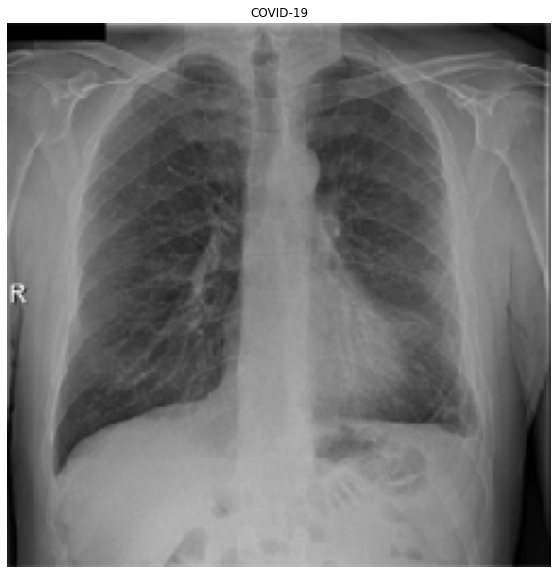

In [20]:
# Test Predictions

img = load_img(r'..\dataset\Test_set\COVID-19\covid_320.png', target_size=(224,224))
img = img_to_array(img)
img_pred = np.expand_dims(img, axis=0)
prediction = np.argmax(model.predict(img_pred))
print(prediction)

pred_class = test_set.class_names[prediction]
print(pred_class)

plt.figure(figsize=(10,10))
plt.imshow(img.astype('uint8'))
plt.title(pred_class)
plt.axis('off')